# Proyecto: Clasificación de Actividades

## Importación de DataFrame

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn as skl
import numpy as np
import scipy as sci
from scipy.stats import mode

DIR='C:\Projects\Physical_activity_classifier/Smartphone_Dataset'

def data_extractor(DIR):
    dataset,error=[],[]
    Activities=['bike','climbing','descending','gymbike','jumping','running','standing','treadmill','walking']
    #print('Extrayendo datos:',end='')
    for suj in range(1,10):#######################10
        print('s0{} '.format(suj),end='')
        new_suj=[[],[],[],[],[],[],[],[],[]]
        for act in range(0,9):###################9
            new_act=[[],[],[],[],[]]
            for k in range(1,6):
                path=DIR+'/S0'+str(suj)+'/'+Activities[act]+str(k)+'.csv'
                try:
                    df=pd.read_csv(path,header=None)
                    data=df.as_matrix()
                    new_act[k-1]=data
                except FileNotFoundError :
                    estr=Activities[act]+str(k)
                    error.append(estr)
            new_suj[act]=new_act
        dataset.append(new_suj)
    print('')
    return dataset

In [2]:
def feature_extractor(dataset,data_size,groups,overlap=0):
    x_data,y_data,error=[],[],[]
    print('Calculando características ...',end=' ')
    for suj in range(0,9):#######################10
        print('s0{} '.format(suj+1),end='')
        for act in range(0,9):###################9
            for k in range(0,5):
                try:
                    data=dataset[suj][act][k]
                    #groups=len(data)//data_size
                    new_data=[]
                    for g in range(0,groups):
                        if(g==0):
                            new_data.append(data[g*data_size:(g+1)*data_size])
                        else:
                            new_data.append(data[g*(data_size-overlap):g*(data_size-overlap)+data_size])
                    for g in range(0,len(new_data)):
                        final_data=[]
                        sensors=[[],[],[],[],[],[],[],[],[]]
                        for i in range(0,data_size):
                            for j in range(0,9):
                                sensors[j].append(new_data[g][i][j])

                        for j in range(0,9):
                            final_data.append(np.mean(sensors[j]))#Mean
                            final_data.append(np.var(sensors[j]))#Var
                            final_data.append(np.min(sensors[j]))#Min
                            final_data.append(np.max(sensors[j]))#Max
                            final_data.append(np.max(sensors[j])-np.min(sensors[j]))#Range
                            RMS=0
                            for i in range(0,data_size):
                                RMS+=np.sqrt((1/data_size)*sensors[j][i]*sensors[j][i])
                            final_data.append(RMS)#RMS
                            final_data.append(sci.stats.kurtosis(sensors[j]))#Kurtosis

                        #-------------------Entropy----------------------
                        for j in range(0,9):
                            H=sci.stats.entropy(sensors[j])
                            #final_data.append(H)    
                        #-------------------EnergyExpenditure----------------------
                        for j in range(0,3):
                            EE=0
                            for i in range(0,data_size):
                                EE+=(1/data_size)*np.sqrt(sensors[0+j*3][i]*sensors[0+j*3][i]+sensors[1+j*3][i]*sensors[1+j*3][i]+sensors[2+j*3][i]*sensors[2+j*3][i])
                            final_data.append(EE)#EE
                            SMA=0
                            for i in range(0,data_size):
                                SMA+=(1/data_size)*(np.abs(sensors[0+j*3][i])+np.abs(sensors[1+j*3][i])+np.abs(sensors[2+j*3][i]))
                            final_data.append(SMA)#SMA    

                        x_data.append(final_data)
                        y_data.append(act)

                except IndexError :
                    estr='actividad '+str(act)+','+str(k)+ 'doesn t exist'
                    error.append(estr)
    print('')
    return x_data,y_data

In [3]:
sensor_names=['Ax','Ay','Az','Gx','Gy','Gz','Mx','My','Mz']
sensors_names=['Acc','Gyr','Mag']
fnames=[]
for j in range(0,9):
    fnames.append(sensor_names[j]+'Mean')
    fnames.append(sensor_names[j]+'Var')
    fnames.append(sensor_names[j]+'Min')
    fnames.append(sensor_names[j]+'Max')
    fnames.append(sensor_names[j]+'Range')
    fnames.append(sensor_names[j]+'RMS')
    fnames.append(sensor_names[j]+'Kurt')
for j in range(0,3):
    fnames.append(sensors_names[j]+'EE')
    fnames.append(sensors_names[j]+'SMA')
print(fnames)
print('Cantidad de caracteristicas: {}'.format(len(fnames)))
Activities=['bike','climbing','descending','gymbike','jumping','running','standing','treadmill','walking']

['AxMean', 'AxVar', 'AxMin', 'AxMax', 'AxRange', 'AxRMS', 'AxKurt', 'AyMean', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AyRMS', 'AyKurt', 'AzMean', 'AzVar', 'AzMin', 'AzMax', 'AzRange', 'AzRMS', 'AzKurt', 'GxMean', 'GxVar', 'GxMin', 'GxMax', 'GxRange', 'GxRMS', 'GxKurt', 'GyMean', 'GyVar', 'GyMin', 'GyMax', 'GyRange', 'GyRMS', 'GyKurt', 'GzMean', 'GzVar', 'GzMin', 'GzMax', 'GzRange', 'GzRMS', 'GzKurt', 'MxMean', 'MxVar', 'MxMin', 'MxMax', 'MxRange', 'MxRMS', 'MxKurt', 'MyMean', 'MyVar', 'MyMin', 'MyMax', 'MyRange', 'MyRMS', 'MyKurt', 'MzMean', 'MzVar', 'MzMin', 'MzMax', 'MzRange', 'MzRMS', 'MzKurt', 'AccEE', 'AccSMA', 'GyrEE', 'GyrSMA', 'MagEE', 'MagSMA']
Cantidad de caracteristicas: 69


In [4]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = 100 * cm / cm.sum(1)
    plt.figure(figsize=(8,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
import time
def NN_train(xdata,ydata,hl_size=10,act='relu'):
    clf = MLPClassifier(activation=act,solver='lbfgs', hidden_layer_sizes=hl_size,
    early_stopping = True, validation_fraction = 0.25);
    
    xtrain,xval,ytrain,yval=train_test_split(xdata,ydata,random_state=clf.random_state,
                                                       test_size=clf.validation_fraction)
    clf.fit(xdata, np.ravel(ydata))
    return [clf,xtrain,xval,ytrain,yval]

def NN(x,y,hl_s,plot=True):
    #print('-------------------------------------------------')
    #print('Neural Network')
    #print('-------------------------------------------------')
    best_cm=None
    best_acc,best_hls=0,0
    for i in range(0,len(hl_s)):
        clf,x_train,x_val,y_train,y_val=NN_train(x,y,hl_size=hl_s[i])
        y_pred=clf.predict(x_val)
        c_m=confusion_matrix(np.ravel(y_val), y_pred)
        acc=accuracy_score(y_val, y_pred)
        if acc>best_acc:
            best_acc=acc
            best_cm=c_m
            best_hls=hl_s[i]
    if(plot):
        title='Matriz de Confusión Red Neuronal con '+str(best_hls)+ ' neuronas'
        #print('Tiempo de entrenamiento: {}s'.format(dt))
        plot_confusion_matrix(best_cm,Activities,normalize=False,title=title)
    #print('Mejor configuración: Tamaño capa oculta {}'.format(best_hls))
    #print('Clasificaciones exitosas: {}%'.format(best_acc*100))
    return x_train,x_val,y_train,y_val,best_acc*100,best_hls

def svm_poly(x_train,y_train,x_test,y_test,degs=[1],plot=True):
    best_cm=None
    best_acc,best_deg=0,0
    for i in range(0,len(degs)):
        clf = SVC(kernel='poly',degree=degs[i])
        clf.fit(x_train, y_train)  
        y_pred=clf.predict(x_test)
        c_m=confusion_matrix(np.ravel(y_test), y_pred)
        acc=accuracy_score(np.ravel(y_test), y_pred)
        if acc>best_acc:
            best_acc=acc
            best_cm=c_m
            best_deg=degs[i]
    
    #print('-------------------------------------------------')
    #print('Support Vector Machine')
    #print('-------------------------------------------------')
    if (plot):
        title='Matriz de Confusión SVM con kernel polinomial grado '+str(best_deg)
        plot_confusion_matrix(best_cm,Activities,title=title)
    #print('Mejor configuración: Polinomio Grado {}'.format(best_deg))
    #print('Clasificaciones exitosas: {}%'.format(acc*100))
    return best_acc*100,best_deg

def NB(x_train,y_train,x_val,y_val,plot=True):
    clf = GaussianNB().fit(x_train, y_train)
    y_pred=clf.predict(x_val)
    c_m=confusion_matrix(np.ravel(y_val), y_pred)
    acc=accuracy_score(np.ravel(y_val), y_pred)
    #print('-------------------------------------------------')
    #print('Gaussian Naive Bayes')
    #print('-------------------------------------------------')
    if(plot):
        title='Matriz de Confusión Clasificador Naive Bayes Gaussiano'
        plot_confusion_matrix(c_m,Activities,title=title)
    #print('Clasificaciones exitosas: {}%'.format(acc*100))
    return acc*100

In [6]:
def clf_results(x,y,hl_s,degs,it=3,plot=False):
    NNacc,SVMacc,GNBacc,NNhls,SVMd=[],[],[],[],[]
    #print('Iteración: ',end='')
    for i in range(0,it):
        #print('{} ... '.format(i+1),end='')
        if(i>0):
            plot=False
        x_train,x_val,y_train,y_val,acc,hls=NN(x,y,hl_s,plot=plot)
        NNacc.append(acc)
        NNhls.append(hls)
        std_scale=skl.preprocessing.StandardScaler().fit(x_train)
        x_train_n = std_scale.transform(x_train)
        x_val_n = std_scale.transform(x_val)

        acc,d=svm_poly(x_train_n,y_train,x_val_n,y_val,degs,plot=plot)
        SVMacc.append(acc)
        SVMd.append(d)
        
        acc=NB(x_train_n,y_train,x_val_n,y_val,plot=plot)
        GNBacc.append(acc)
    print('')
    print('---------------------------------------')
    print('Resultados')
    print('---------------------------------------')
    print('Precisión Red Neuronal: {}%'.format(np.mean(NNacc)))
    print('Configuraciones: {} Neuronas'.format(NNhls))
    print('---------------------------------------')
    print('Precisión Support Vector Machine: {}%'.format(np.mean(SVMacc)))
    print('Configuraciones: grado {} '.format(SVMd))
    print('---------------------------------------')
    print('Precisión Naive Bayes Gaussiano: {}%'.format(np.mean(GNBacc)))
        
    return x_train,y_train

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
def f_selection(k,x_train,y_train,x,fnames,plot=False):
    sel = SelectKBest(score_func=mutual_info_classif,k=k).fit(x_train, y_train)
    x2= sel.transform(x)
    print('---------------------------------------------------')
    print('feature size: {} ---> {}'.format(len(x[0]),len(x2[0])))
    if (plot):
        scores=sel.scores_
        feature_s=len(x[0])
        features=np.arange(0,feature_s,1)
        plt.figure(figsize=(15,15))
        plt.barh(range(feature_s),scores)
        plt.yticks(range(feature_s),fnames)
        plt.show()

    mask=sel.get_support()
    fnames2=get_fnames(fnames,mask)
    print('características seleccionadas:')
    print(fnames2)
    return x2,fnames2

def get_fnames(fnames,mask):
    fnames2=[]
    for i in range(0,len(fnames)):
        if(mask[i]):
            fnames2.append(fnames[i])
    return fnames2

## Extracción de datos

In [8]:
dataset=data_extractor(DIR)
x_data,y_data=feature_extractor(dataset,500,1)
    
print('Cantidad de datos: {}'.format(len(x_data)))
print('Cantidad de caracteristicas: {}'.format(len(x_data[0])))

x,x_test,y,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)

Extrayendo datos:s01 s02 s03 s04 s05 s06 s07 s08 s09 
Calculando características ... s01 s02 s03 s04 s05 s06 s07 s08 s09 
Cantidad de datos: 383
Cantidad de caracteristicas: 69


## Clasificadores

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 98.26839826839826%
Configuraciones: [[100, 100], 500, 100] Neuronas
---------------------------------------
Precisión Support Vector Machine: 83.54978354978356%
Configuraciones: grado [1, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 88.31168831168831%


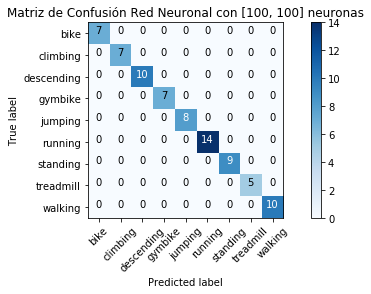

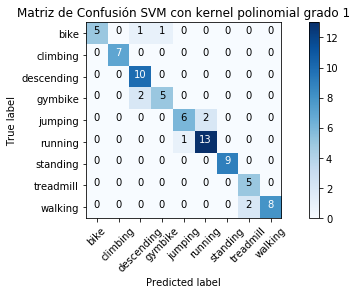

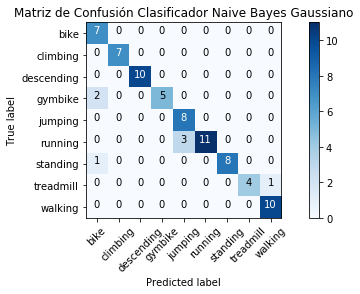

In [9]:
hl_s=[10,50,100,500,[10,10],[50,50],[100,100]] #hl_size_op=5000#(28+10)//2
degs=[1,2,3]

x_train,y_train=clf_results(x,y,hl_s,degs,it=3,plot=True)

## Selección de características

feature size: 69 ---> 30


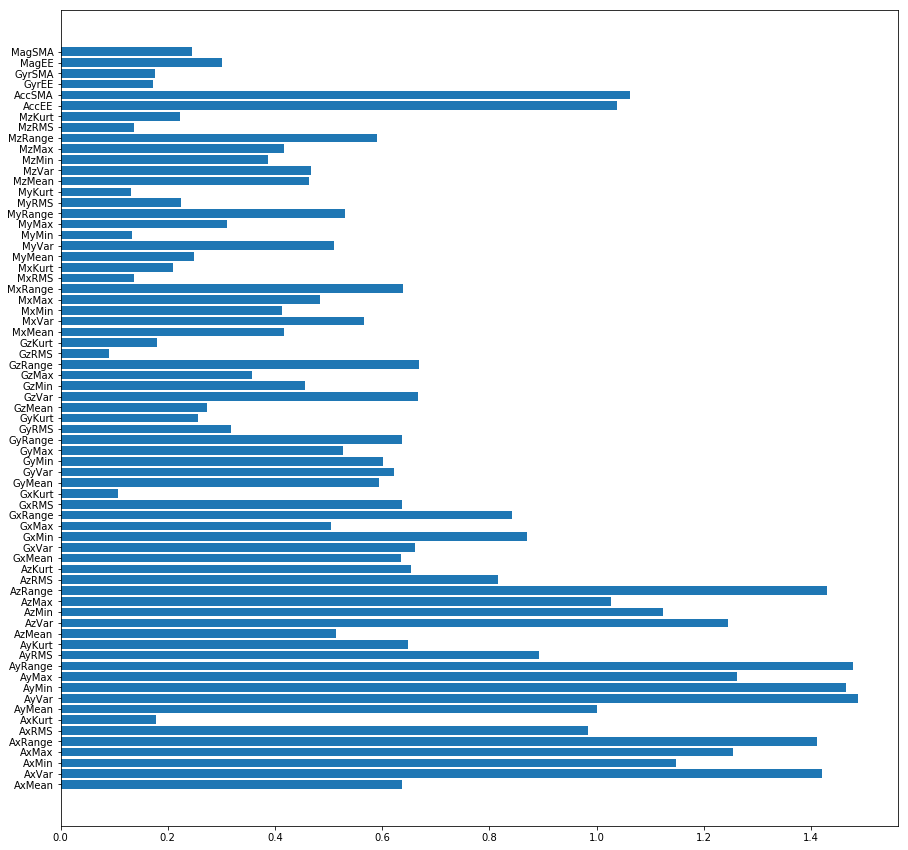

características seleccionadas:
['AxMean', 'AxVar', 'AxMin', 'AxMax', 'AxRange', 'AxRMS', 'AyMean', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AyRMS', 'AyKurt', 'AzVar', 'AzMin', 'AzMax', 'AzRange', 'AzRMS', 'AzKurt', 'GxMean', 'GxVar', 'GxMin', 'GxRange', 'GxRMS', 'GyRange', 'GzVar', 'GzRange', 'MxRange', 'AccEE', 'AccSMA']


In [10]:
x2,fnames2=f_selection(30,x_train,y_train,x,fnames,plot=True)

In [11]:
x_train,y_train=clf_results(x2,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 96.53679653679654%
Configuraciones: [100, 100, 100] Neuronas
---------------------------------------
Precisión Support Vector Machine: 70.995670995671%
Configuraciones: grado [1, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 79.65367965367966%


## Tercera Selección de Caracteríticas

In [12]:
x3,fnames3=f_selection(10,x_train,y_train,x2,fnames2)

feature size: 30 ---> 10
características seleccionadas:
['AxVar', 'AxMax', 'AxRange', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AzVar', 'AzMin', 'AzRange']


In [13]:
x_train,y_train=clf_results(x3,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 91.34199134199135%
Configuraciones: [50, 10, 500] Neuronas
---------------------------------------
Precisión Support Vector Machine: 69.6969696969697%
Configuraciones: grado [1, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 82.68398268398268%


# Extracción de Datos (tamaño 250)

In [14]:
x_data,y_data=feature_extractor(dataset,250,2)
print('Cantidad de datos: {}'.format(len(x_data)))
print('Cantidad de caracteristicas: {}'.format(len(x_data[0])))
x,x_test,y,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)

Calculando características ... s01 s02 s03 s04 s05 s06 s07 s08 s09 
Cantidad de datos: 766
Cantidad de caracteristicas: 69


In [15]:
x_train,y_train=clf_results(x,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 98.25708061002179%
Configuraciones: [[100, 100], 500, [100, 100]] Neuronas
---------------------------------------
Precisión Support Vector Machine: 90.63180827886713%
Configuraciones: grado [2, 2, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 91.50326797385621%


In [16]:
x2,fnames2=f_selection(10,x_train,y_train,x,fnames)

feature size: 69 ---> 10
características seleccionadas:
['AxVar', 'AxMin', 'AxMax', 'AxRange', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AzVar', 'AzRange']


In [17]:
x_train,y_train=clf_results(x2,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 88.8888888888889%
Configuraciones: [500, 100, 100] Neuronas
---------------------------------------
Precisión Support Vector Machine: 70.37037037037037%
Configuraciones: grado [2, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 77.99564270152506%


# Extracción de Datos (tamaño 100)

In [18]:
x_data,y_data=feature_extractor(dataset,100,5)
print('Cantidad de datos: {}'.format(len(x_data)))
print('Cantidad de caracteristicas: {}'.format(len(x_data[0])))
x,x_test,y,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)

Calculando características ... s01 s02 s03 s04 s05 s06 s07 s08 s09 
Cantidad de datos: 1915
Cantidad de caracteristicas: 69


In [19]:
hl_s=[50,100,[50,50]]
x_train,y_train=clf_results(x,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 93.99477806788512%
Configuraciones: [100, 100, [50, 50]] Neuronas
---------------------------------------
Precisión Support Vector Machine: 95.47432550043516%
Configuraciones: grado [2, 2, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 90.42645778938207%


In [20]:
x2,fnames2=f_selection(10,x_train,y_train,x,fnames)
x_train,y_train=clf_results(x2,y,hl_s,degs,it=3)

feature size: 69 ---> 10
características seleccionadas:
['AxVar', 'AxMin', 'AxMax', 'AxRange', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AzVar', 'AzRange']
Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 84.24717145343777%
Configuraciones: [100, 100, 100] Neuronas
---------------------------------------
Precisión Support Vector Machine: 74.84769364664926%
Configuraciones: grado [2, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 77.11053089643168%


In [21]:
x_data,y_data=feature_extractor(dataset,300,2,overlap=100)
print('Cantidad de datos: {}'.format(len(x_data))) #1532
print('Cantidad de caracteristicas: {}'.format(len(x_data[0])))
x,x_test,y,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)

Calculando características ... s01 s02 s03 s04 s05 s06 s07 s08 s09 
Cantidad de datos: 766
Cantidad de caracteristicas: 69


In [22]:
x_train,y_train=clf_results(x,y,hl_s,degs,it=3)
x2,fnames2=f_selection(10,x_train,y_train,x,fnames)
x_train,y_train=clf_results(x2,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 91.28540305010893%
Configuraciones: [[50, 50], [50, 50], [50, 50]] Neuronas
---------------------------------------
Precisión Support Vector Machine: 90.41394335511983%
Configuraciones: grado [1, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 89.97821350762528%
feature size: 69 ---> 10
características seleccionadas:
['AxVar', 'AxMin', 'AxMax', 'AxRange', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AzVar', 'AzRange']
Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 88.88888888888887%
Configuraciones: [100, 100, 50] Neuronas
---------------------------------------
Precisión Support Vector Machine: 74.29193899782136%
Configuraciones: grado [3, 1, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 77

In [23]:
x_data,y_data=feature_extractor(dataset,200,4,overlap=100)
print('Cantidad de datos: {}'.format(len(x_data))) #1532
print('Cantidad de caracteristicas: {}'.format(len(x_data[0])))
x,x_test,y,y_test=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)

Calculando características ... s01 s02 s03 s04 s05 s06 s07 s08 s09 
Cantidad de datos: 1532
Cantidad de caracteristicas: 69


In [24]:
x_train,y_train=clf_results(x,y,hl_s,degs,it=3)
x2,fnames2=f_selection(10,x_train,y_train,x,fnames)
x_train,y_train=clf_results(x2,y,hl_s,degs,it=3)

Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 92.94245385450597%
Configuraciones: [[50, 50], 50, [50, 50]] Neuronas
---------------------------------------
Precisión Support Vector Machine: 95.33116178067318%
Configuraciones: grado [2, 2, 2] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 91.31378935939195%
feature size: 69 ---> 10
características seleccionadas:
['AxVar', 'AxMin', 'AxMax', 'AxRange', 'AyVar', 'AyMin', 'AyMax', 'AyRange', 'AzVar', 'AzRange']
Iteración: 1 ... 2 ... 3 ... 
---------------------------------------
Resultados
---------------------------------------
Precisión Red Neuronal: 87.94788273615636%
Configuraciones: [50, 100, 100] Neuronas
---------------------------------------
Precisión Support Vector Machine: 76.4386536373507%
Configuraciones: grado [1, 2, 1] 
---------------------------------------
Precisión Naive Bayes Gaussiano: 81.758957